# Insider ML Engineer Challenge - Titanic Dataset

In this challenge, we are going to develop a full API to use it with AI.

The Titanic Dataset can be found at [Kaggle](https://www.kaggle.com/competitions/titanic/data), but in this case, it is already downloaded in the [`dataset directory`](../dataset), due to its small size.

## Requirements

- Python 3

### Preparing the environment

PS: The following commands may be used on a Linux terminal.

First, we need to create and activate our virtual environment (venv):

```bash
python3 -m venv venv && source venv/bin/activate
```

Then, using pip, we must download the dependecies from [`requirements.txt`](../requirements.txt)

```bash
pip install -r requirements.txt
```

### Git LFS

It is also good to install the Git LFS for uploading models to GitHub.
In Linux systems, especifically Debian based like Ubuntu, we can do this in the terminal running:

```bash
sudo apt install git-lfs
```

Then, we must initialize Git LFS in our project directory:

```bash
git lfs install
```

Now, we need to make it track our pickle files (in this case, there is just one file):

```bash
git lfs track "*.pkl"
```

This will create (or update) our [`.gitattributes`](../.gitattributes) file, which will not store the content in the Git repository, but link it into GitHub. In this way, we will not upload these bigger files, but just a link to it.

In this challenge, our models will be quite small, but we still will be using Git LFS because of real-world good practices.

## Code

One way to start is by knowing that the [`gender_submission file`](../dataset/gender_submission.csv) assumes that all women survived and all men died. This is based on the priority of women and children first in accident cases. With this file, we get a **0.76555** score in Kaggle, we can use this value to estimate a minimum threshold for our AI to exceed.

Let's start importing our dependencies and then checking if the gender is a good parameter.

### Importing Dependecies

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

%matplotlib inline

### Load dataset

In [5]:
train_df = pd.read_csv("../dataset/train.csv")
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
test_df = pd.read_csv("../dataset/test.csv")
test_df.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


### Defining a threshold based in gender

In [7]:
# Print survival rates by sex
for sex in ["female", "male"]:
    rate = train_df.loc[train_df["Sex"] == sex, "Survived"].mean()
    print(f"% of {sex} who survived: {rate:.2%}")

% of female who survived: 74.20%
% of male who survived: 18.89%


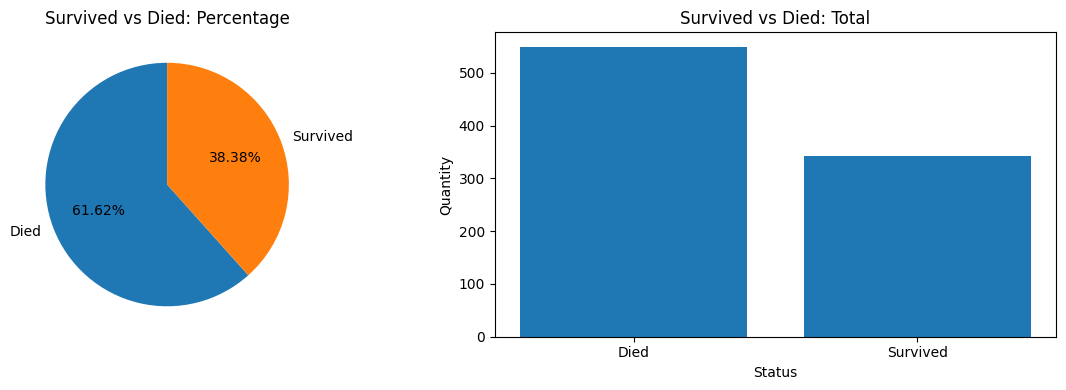

In [8]:
# Map for clearer labels
survival_labels = {0: "Died", 1: "Survived"}

# Count values and rename index for clarity
survived_counts = train_df["Survived"].value_counts().sort_index()
survived_counts.index = survived_counts.index.map(survival_labels)

# Pie + Bar plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart
survived_counts.plot.pie(
    autopct="%1.2f%%",
    startangle=90,
    ax=ax[0],
    labels=survived_counts.index
)
ax[0].set_title("Survived vs Died: Percentage")
ax[0].set_ylabel("")

# Bar chart
ax[1].bar(survived_counts.index, survived_counts.values)
ax[1].set_title("Survived vs Died: Total")
ax[1].set_xlabel("Status")
ax[1].set_ylabel("Quantity")

plt.tight_layout()
plt.show()

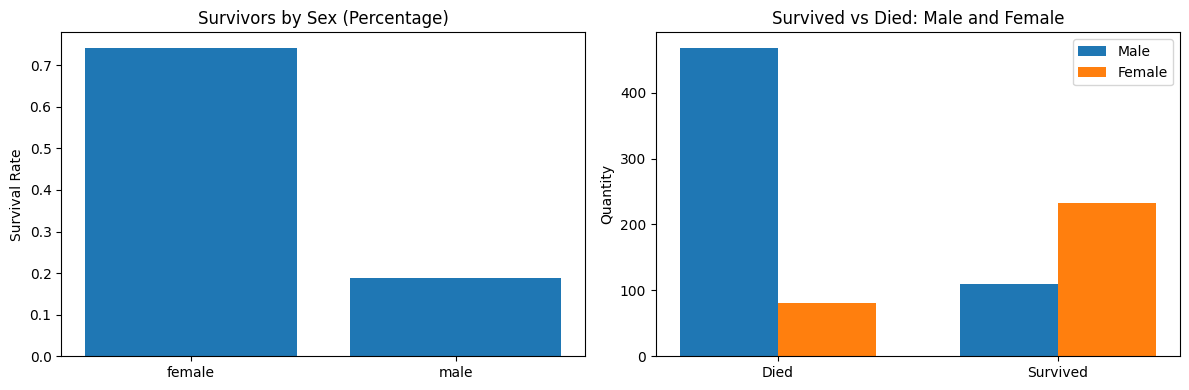

In [9]:
# Survival rate by sex + Grouped bar chart by sex/survival
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart: Survival rate by sex
sex_rate = train_df.groupby("Sex")["Survived"].mean()
ax[0].bar(sex_rate.index, sex_rate.values)
ax[0].set_title("Survivors by Sex (Percentage)")
ax[0].set_ylabel("Survival Rate")

# Grouped bar chart: Count of survived vs died by sex
bar_width = 0.35
x = [0, 1]  # 0 = died, 1 = survived
sexes = ["male", "female"]

for i, sex in enumerate(sexes):
    counts = train_df[train_df["Sex"] == sex]["Survived"].value_counts().sort_index()
    offsets = [val - bar_width/2 + i * bar_width for val in x]
    ax[1].bar(offsets, counts.values, width=bar_width, label=sex.capitalize())

ax[1].set_xticks(x)
ax[1].set_xticklabels(["Died", "Survived"])
ax[1].set_ylabel("Quantity")
ax[1].set_title("Survived vs Died: Male and Female")
ax[1].legend()

plt.tight_layout()
plt.show()

Now, we know that the gender is in fact a solid data.  
Our objective will be to make an AI capable of surpassing the threshold of 0.76555 score, to determine that is better than this pure intuition.

The code above is a slightly modification of the [Tutorial Notebook](https://www.kaggle.com/code/alexisbcook/titanic-tutorial) found pinned in the official Titanic Kaggle dataset page.  
From now on, we will be making our own pre-processing, exploratory data analysis (EDA), feature engineering, model, evaluation, etc.

In [10]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (891, 12)
Test shape: (418, 11)


### EDA

In [11]:
# Checking null values

print("Checking null values:\n")
print(train_df.isnull().sum())
print("\n")
print("Verifying data types:\n")
print(train_df.info()) 

Checking null values:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Verifying data types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2)

In [12]:
# Take a look at the central tendencies of the numerical categories
print(train_df.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [13]:
# Separate categorical columns from numerical columns

num_col_df = train_df[["Age", "SibSp", "Parch", "Fare"]]
cat_col_df = train_df[["Survived", "Pclass", "Sex", "Ticket", "Cabin", "Embarked"]]

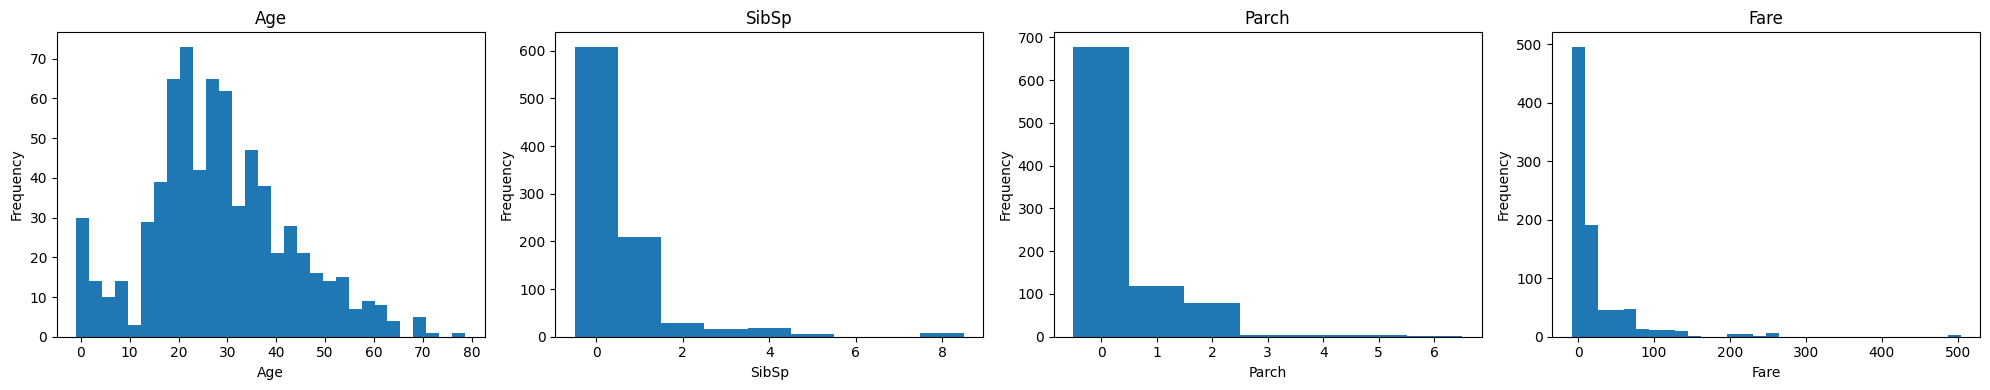

In [14]:
# Visualizing the distribution of numerical columns

num_cols = len(num_col_df.columns)

# Single line
fig, axes = plt.subplots(1, num_cols, figsize=(5 * num_cols, 4))

# Create histograms
for ax, column in zip(axes, num_col_df.columns):
    data = num_col_df[column].dropna()
    min_val, max_val = data.min(), data.max()
    
    # Defining bins
    if data.dtype == "int" or column in ["SibSp", "Parch"]:
        bins = range(int(min_val), int(max_val) + 2)
    else:
        bins = 30

    ax.hist(data, bins=bins, align='left')
    ax.set_title(f"{column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [15]:
# Mean of numerical columns
# 1 = survived
# 0 = not survived

pd.pivot_table(train_df, index = 'Survived', values = num_col_df)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


As we can see, people with a bigger Fare was more likely to survive

We may also analyze the categorical columns

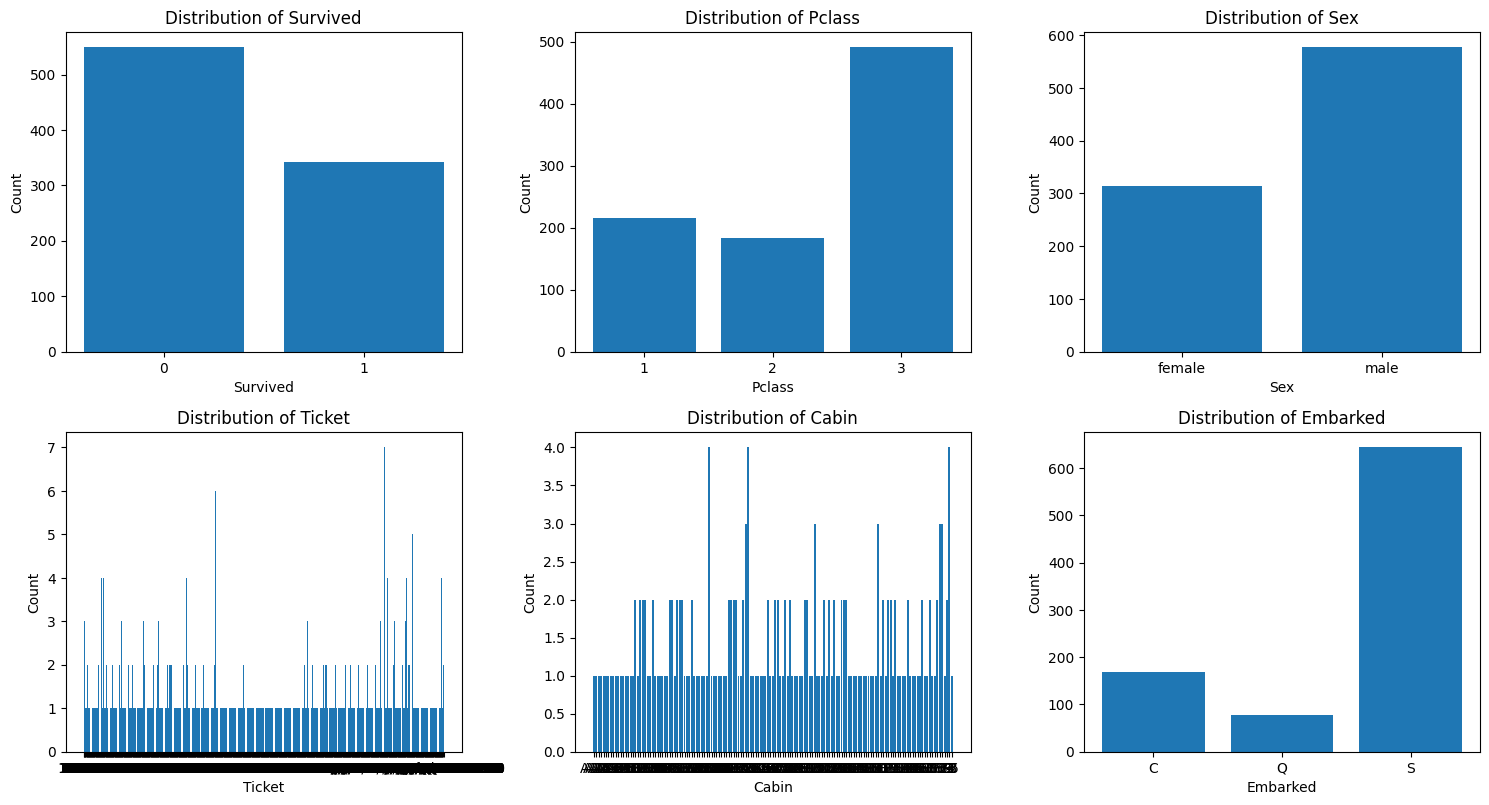

In [16]:
# Define layout
plots_per_row = 3
num_features = len(cat_col_df)
num_rows = (num_features + plots_per_row - 1) // plots_per_row  # Ceiling division

# Create subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 5, num_rows * 4))
axes = axes.flatten()

# Plot each categorical feature
for i, col in enumerate(cat_col_df):
    value_counts = train_df[col].value_counts().sort_index()
    axes[i].bar(value_counts.index.astype(str), value_counts.values)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

As we can see, there are categorical columns like Cabin and Ticket with unreadable data. So we need to make some feature engineering.  
Another important feature to analyze is the name, since the dataset shows a title for each individual. Military workers maybe would prioritize civilians instead of themselves, for example.

We are going to check if the number of Cabins is important. The same will be done to the type of Cabin.

In [17]:
# Comparing survival of the already good categorical columns
print(pd.pivot_table(train_df, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train_df, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train_df, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


In [18]:
cat_col_df.Cabin
train_df['cabin_multiple'] = train_df.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

print(train_df['cabin_multiple'].value_counts())
print()
print(pd.pivot_table(train_df, index = 'Survived', columns = 'cabin_multiple', values = 'Ticket' ,aggfunc ='count'))

cabin_multiple
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64

cabin_multiple      0      1    2    3    4
Survived                                   
0               481.0   58.0  7.0  3.0  NaN
1               206.0  122.0  9.0  3.0  2.0


As we can see, there are a small number of passengers with multiple cabins, and a lot of null or NaNs

In [19]:
train_df['cabin_categories'] = train_df.Cabin.apply(lambda x: str(x)[0])
print(train_df.cabin_categories.value_counts())
pd.pivot_table(train_df,index='Survived',columns='cabin_categories', values = 'Name', aggfunc='count')

cabin_categories
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64


cabin_categories,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


Comparing how many Tickets are numeric or not

In [20]:
# Identify whether the ticket is numeric
train_df["numeric_ticket"] = train_df["Ticket"].apply(
    lambda x: 1 if x.isnumeric() else 0
)

# Extract ticket prefix by removing the last element, cleaning punctuation, and converting to lowercase
train_df["ticket_prefix"] = train_df["Ticket"].apply(
    lambda x: (
        "".join(x.split(" ")[:-1]).replace(".", "").replace("/", "").lower()
        if len(x.split(" ")[:-1]) > 0
        else 0
    )
)

# Count how many tickets are numeric vs alphanumeric
print(train_df["numeric_ticket"].value_counts())
print()

# Comparing survival rate
print(pd.pivot_table(train_df,index='Survived',columns='numeric_ticket', values = 'Ticket', aggfunc='count'))
print()

# Survival rate by ticket type
pd.pivot_table(train_df,index='Survived',columns='ticket_prefix', values = 'Ticket', aggfunc='count')

numeric_ticket
1    661
0    230
Name: count, dtype: int64

numeric_ticket    0    1
Survived                
0               142  407
1                88  254



ticket_prefix,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


Now, let's take a look at the passenger's title in name

In [21]:
# Extract title from Name
train_df['name_title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Check how many passengers belong to each title
print(train_df['name_title'].value_counts())
print()

# Compare survival counts by title
print(pd.pivot_table(train_df, index='Survived', columns='name_title', values='Name', aggfunc='count'))


name_title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

name_title  Capt  Col  Don   Dr  Jonkheer  Lady  Major  Master   Miss  Mlle  \
Survived                                                                      
0            1.0  1.0  1.0  4.0       1.0   NaN    1.0    17.0   55.0   NaN   
1            NaN  1.0  NaN  3.0       NaN   1.0    1.0    23.0  127.0   2.0   

name_title  Mme     Mr   Mrs   Ms  Rev  Sir  the Countess  
Survived                                                   
0           NaN  436.0  26.0  NaN  6.0  NaN           NaN  
1           1.0   81.0  99.0  1.0  NaN  1.0           1.0  


### Pre Processing

In this section, we will be treating null/NaN values, make categorical transforms in data, drop "useless" columns, calculate the median of some numerical columns and use standard scaler.  
This part will be based in previous works that I already did with this dataset 

In [22]:
train_df["train_test_join"] = 1
test_df["train_test_join"] = 0

test_df["Survived"] = -1 # Creating column Survived in test split

train_test_df = pd.concat([train_df, test_df]) # We will group them for general analysis

train_test_df.tail(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_multiple,cabin_categories,numeric_ticket,ticket_prefix,name_title,train_test_join
408,1300,-1,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q,NaN,NaN,NaN,NaN,NaN,0
409,1301,-1,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,NaN,NaN,NaN,NaN,NaN,0
410,1302,-1,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q,NaN,NaN,NaN,NaN,NaN,0
411,1303,-1,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C78,Q,NaN,NaN,NaN,NaN,NaN,0
412,1304,-1,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S,NaN,NaN,NaN,NaN,NaN,0
413,1305,-1,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,NaN,NaN,NaN,NaN,NaN,0
414,1306,-1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,NaN,NaN,NaN,NaN,NaN,0
415,1307,-1,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,NaN,NaN,NaN,NaN,NaN,0
416,1308,-1,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN,NaN,NaN,NaN,NaN,0
417,1309,-1,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,NaN,NaN,NaN,NaN,NaN,0


We need to treat those NaN values in our new columns

In [23]:
# Fill null with the median age and fare
train_test_df.Age = train_test_df.Age.fillna(train_test_df.Age.median())
train_test_df.Fare = train_test_df.Fare.fillna(train_test_df.Fare.median())

# Droping null values in Embarked (only 2 occurrencies)
train_test_df.dropna(subset=['Embarked'],inplace = True)

# Normalizing Fare
train_test_df['norm_fare'] = np.log(train_test_df.Fare+1)

# Preparing Pclass for one hot enconding
train_test_df.Pclass = train_test_df.Pclass.astype(str)

Creating categorical columns

In [24]:
# Count how many cabins a person has (0 if missing, otherwise count how many space-separated entries)
train_test_df['cabin_multiple'] = train_test_df.Cabin.apply(
    lambda x: 0 if pd.isna(x) else len(x.split(' '))
)

# Take the first letter of the cabin string (e.g., 'C85' → 'C'; NaN becomes 'n')
train_test_df['cabin_categories'] = train_test_df.Cabin.apply(
    lambda x: str(x)[0]
)

# Create a binary column: 1 if the ticket is purely numeric, 0 otherwise
train_test_df['numeric_ticket'] = train_test_df.Ticket.apply(
    lambda x: 1 if x.isnumeric() else 0
)

# Extract the prefix of the ticket (remove dots, slashes, and convert to lowercase)
train_test_df['ticket_prefix'] = train_test_df.Ticket.apply(
    lambda x: (
        ''.join(x.split(' ')[:-1])
        .replace('.', '')
        .replace('/', '')
        .lower()
        if len(x.split(' ')[:-1]) > 0 else 0
    )
)

# Extract the title from the name (e.g., "Mr", "Mrs", "Miss", etc.)
train_test_df['name_title'] = train_test_df.Name.apply(
    lambda x: x.split(',')[1].split('.')[0].strip()
)


In [25]:
# Converting 
train_test_df.Pclass = train_test_df.Pclass.astype(str)

# Define categorical and numeric features
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'cabin_categories', 'name_title']
numerical_cols = ['Age', 'SibSp', 'Parch', 'norm_fare', 'cabin_multiple', 'numeric_ticket']
meta_col = ['train_test_join']  # used to split train/test later

# Apply one-hot encoding only to categorical columns
categorical_dummies = pd.get_dummies(train_test_df[categorical_cols])

# Combine with numerical + meta columns
train_test_dummies = pd.concat([
    train_test_df[numerical_cols + meta_col].reset_index(drop=True),
    categorical_dummies.reset_index(drop=True)
], axis=1)

In [26]:
train_test_df.tail(25)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_multiple,cabin_categories,numeric_ticket,ticket_prefix,name_title,train_test_join,norm_fare
393,1285,-1,2,"Gilbert, Mr. William",male,47.0,0,0,C.A. 30769,10.5000,NaN,S,0,n,0,ca,Mr,0,2.442347
394,1286,-1,3,"Kink-Heilmann, Mr. Anton",male,29.0,3,1,315153,22.0250,NaN,S,0,n,1,0,Mr,0,3.136581
395,1287,-1,1,"Smith, Mrs. Lucien Philip (Mary Eloise Hughes)",female,18.0,1,0,13695,60.0000,C31,S,1,C,1,0,Mrs,0,4.110874
396,1288,-1,3,"Colbert, Mr. Patrick",male,24.0,0,0,371109,7.2500,NaN,Q,0,n,1,0,Mr,0,2.110213
397,1289,-1,1,"Frolicher-Stehli, Mrs. Maxmillian (Margaretha ...",female,48.0,1,1,13567,79.2000,B41,C,1,B,1,0,Mrs,0,4.384524
398,1290,-1,3,"Larsson-Rondberg, Mr. Edvard A",male,22.0,0,0,347065,7.7750,NaN,S,0,n,1,0,Mr,0,2.171907
399,1291,-1,3,"Conlon, Mr. Thomas Henry",male,31.0,0,0,21332,7.7333,NaN,Q,0,n,1,0,Mr,0,2.167143
400,1292,-1,1,"Bonnell, Miss. Caroline",female,30.0,0,0,36928,164.8667,C7,S,1,C,1,0,Miss,0,5.111184
401,1293,-1,2,"Gale, Mr. Harry",male,38.0,1,0,28664,21.0000,NaN,S,0,n,1,0,Mr,0,3.091042
402,1294,-1,1,"Gibson, Miss. Dorothy Winifred",female,22.0,0,1,112378,59.4000,NaN,C,0,n,1,0,Miss,0,4.100989


In [27]:
# Split train and test
X_full_train = train_test_dummies[train_test_dummies.train_test_join == 1].drop(['train_test_join'], axis=1)
X_test = train_test_dummies[train_test_dummies.train_test_join == 0].drop(['train_test_join'], axis=1)
y_full_train = train_test_df[train_test_df.train_test_join == 1].Survived

# Split training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_full_train,
    y_full_train,
    test_size=0.2,
    random_state=29,
    stratify=y_full_train
)

# Scale data
scale = StandardScaler()

# Columns to scale
columns_to_scale = ['Age', 'SibSp', 'Parch', 'norm_fare']

# Fit scaler only on X_train, then transform all
X_train[columns_to_scale] = scale.fit_transform(X_train[columns_to_scale])
X_val[columns_to_scale] = scale.transform(X_val[columns_to_scale])
X_test[columns_to_scale] = scale.transform(X_test[columns_to_scale])

### Model

The RandomForest and SVC models were chosen based on previous personal works with this dataset

In [28]:
rf_model = RandomForestClassifier(random_state=29)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

# Evaluation
print("Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print("F1 Score:", f1_score(y_val, y_pred_rf))
print("Precision:", precision_score(y_val, y_pred_rf))
print("Recall:", recall_score(y_val, y_pred_rf))

Random Forest Evaluation:
Accuracy: 0.8258426966292135
F1 Score: 0.7703703703703704
Precision: 0.7761194029850746
Recall: 0.7647058823529411


In [29]:
svm_model = SVC(random_state=29)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

# Evaluation
print("SVC Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print("F1 Score:", f1_score(y_val, y_pred_svm))
print("Precision:", precision_score(y_val, y_pred_svm))
print("Recall:", recall_score(y_val, y_pred_svm))

SVC Evaluation:
Accuracy: 0.8539325842696629
F1 Score: 0.8088235294117647
Precision: 0.8088235294117647
Recall: 0.8088235294117647


### Fine-tuning

In [32]:
def clf_performance(model, name):
    print(f"\nBest {name} Model Evaluation:")
    print("Best parameters:", model.best_params_)
    
    y_pred = model.predict(X_val)
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("F1 Score:", f1_score(y_val, y_pred))
    print("Precision:", precision_score(y_val, y_pred))
    print("Recall:", recall_score(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))

In [35]:
rf = RandomForestClassifier(random_state=29)
param_grid_rf = {
    'n_estimators': [100, 200, 400, 500],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True],
    'max_depth': [15, 20, 25],
    'max_features': ['log2', 'sqrt', 10],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 3]
}

clf_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv=5, verbose=2, n_jobs=-1)
best_clf_rf = clf_rf.fit(X_train, y_train)
clf_performance(best_clf_rf, 'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[CV] END bootstrap=True, criterion=gini, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, criterion=gini, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, criterion=gini, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, criterion=gini, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, criterion=gini, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, criterion=gini, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, criterion=gini, max_depth=15, max_features=log2, min_samples_le

In [36]:
# SVC 
svc = SVC(probability=True)
param_grid_svc = [
    {'kernel': ['rbf'], 'gamma': [0.1, 0.5, 1, 2, 5, 10], 'C': [0.1, 1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]},
    {'kernel': ['poly'], 'degree': [2, 3, 4, 5], 'C': [0.1, 1, 10, 100, 1000]}
]

clf_svc = GridSearchCV(svc, param_grid=param_grid_svc, cv=5, verbose=2, n_jobs=-1)
best_clf_svc = clf_svc.fit(X_train, y_train)
clf_performance(best_clf_svc, 'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.5, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.5, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.5, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.5, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.5, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=

Comparing both SVC and Random Forest, the result is that overall, the best approach is using the SVC method.  
There is a better way to make a good analysis using the collected metrics, but for this case where we are going to test it in Kaggle, we will use the model with best macro average.   
We could also create an Ensemble of the top SVC models, but for now, we will just use the best one of each type of model.

In [47]:
joblib.dump(best_clf_svc.best_estimator_, '../models/best_svc_model.pkl')
joblib.dump(best_clf_rf.best_estimator_, '../models/best_rf_model.pkl')

['../models/best_rf_model.pkl']

### Testing both models in Kaggle

In [46]:
test_df.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test_join,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,-1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,-1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,-1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,-1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,-1
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0,-1
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0,-1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0,-1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,0,-1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0,-1


In [42]:
svc_model = joblib.load('../models/best_svc_model.pkl')

y_test_pred = svc_model.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred.astype(int)
})

# Export to CSV
submission.to_csv("../svc_submission.csv", index=False)
print("Submission file created: svc_submission.csv")


Submission file created: svc_submission.csv


In [45]:
rf_model = joblib.load('../models/best_rf_model.pkl')

y_test_pred = rf_model.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred.astype(int)
})

# Export to CSV
submission.to_csv("../rf_submission.csv", index=False)
print("Submission file created: rf_submission.csv")


Submission file created: rf_submission.csv


### Kaggle Score

![Submissions](../docs/submissions.png)

As we can see, the SVC model was in fact the one with best score, but both approaches surpassed the gender_submission file.  
This gives us the position of 2383th, top 15.65%, considering even the 251 people, top 1.65%, that has a 1.0 impossible score on the challenge.  
Therefore, our model is better than a simple intuition and it is worth to use it.